<a href="https://colab.research.google.com/github/sadeelmu/deeplearning/blob/main/Model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<style>
r { color: Red }
o { color: Orange }
g { color: Green }
b { color: Blue }
l { color: lighblue }
</style>


<html>
<body>
<table style="border: 0; rules=none; font-size:28px">
<tr>
<th rowspan=5><img width="200px", height="70px" src="https://raw.githubusercontent.com/camma-public/multibypass140/master/static/camma_logo_tr.png"/></th>
<td colspan=2 style="font-size:16px; color:blue; font-weight:bold"><h1><b>Deep Learning for Computer Vision</b></h1></td>
<th rowspan=5><img width="200px", height="130px" src="https://community.sap.com/legacyfs/online/storage/blog_attachments/2019/10/283545_NeuralNetwork_R_blue.png"/></th>
</tr>
<tr><td>Instructor:</td><td>Dr. Chinedu Nwoye</td></tr>
<tr><td colspan=2>(c) Research Group CAMMA</td></tr>
<tr><td colspan=2>University of Strasbourg</td></tr>
<tr><td>Website:</td><td><g>http://camma.u-strasbg.fr</g></td></tr>
<tr><td colspan=4 style="text-align:centre; background-color:black; font-weight:bold"><center><h3><o>Deep Learning Model Training </o></td></center></tr>
</table>
</body>
</html>

--------

### Instructions

- In this lab session we will go over the detailed implementation of a training loop for a CNN model.
- Read all the descriptions and code.
- Run the pre-completed cells.
- Fill in the `TODO`blocks and run the code.
- The exercises are *highly repetitive* meant to train your fundamentals, without the comfort of high-level APIs.
- You will have to identify overfitting scenarios and adjust your training process accordingly using the methods presented during the lecture.
* Please ask questions if you have any doubts.
* You also have an additional `Bonus` exercise if you finish very quickly.

### GPU activation

- Be sure to have cuda enabled from your computer.

### Imports

- Every experiments starts with importing the required libraries.
- Check and see what libraries you don't know their usage.



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision.transforms import ToTensor, ToPILImage, Resize
import matplotlib.pyplot as plt
import importlib as ipl
import numpy as np
import random
import pickle
import os
import urllib
from timeit import default_timer as timer
import gc
from zipfile import ZipFile

# check the PyTorch version;
print("PyTorch version: ", torch.__version__)
print("torchvision version: ", torchvision.__version__)

# check the GPU support; shold be yes
print("Is GPU available?: ", torch.cuda.is_available())
filepath='RPS'

PyTorch version:  2.5.0+cu121
torchvision version:  0.20.0+cu121
Is GPU available?:  True


# Section 1: Dataset

We will use an image dataset of 4 classes for moves in this lab session.


**[1.1] Download data**

- Download RPS dataset (https://seafile.unistra.fr/f/2d58c54203e6435fbf22/?dl=1)

In [ ]:
# run to download data

!wget https://seafile.unistra.fr/f/2d58c54203e6435fbf22/?dl=1 --content-disposition &&  unzip -qq RPS.zip -d RPS/

--2024-11-15 16:17:06--  https://seafile.unistra.fr/f/2d58c54203e6435fbf22/?dl=1
Resolving seafile.unistra.fr (seafile.unistra.fr)... 77.72.44.41
Connecting to seafile.unistra.fr (seafile.unistra.fr)|77.72.44.41|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://seafile.unistra.fr/seafhttp/files/6570c331-b1d8-4225-91ca-289302188fcd/RPS.zip [following]
--2024-11-15 16:17:07--  https://seafile.unistra.fr/seafhttp/files/6570c331-b1d8-4225-91ca-289302188fcd/RPS.zip
Reusing existing connection to seafile.unistra.fr:443.
HTTP request sent, awaiting response... 200 OK
Length: 159672684 (152M) [application/zip]
Saving to: ‘RPS.zip’

RPS.zip             100%[===================>] 152.28M  12.9MB/s    in 14s     

2024-11-15 16:17:21 (11.2 MB/s) - ‘RPS.zip’ saved [159672684/159672684]



**[1.2] Data preparation**
- We will be packaging the data into a PyTorch datasets.
- We will add basic preprocessing of image resizing,
- We will split the data into train/val/test sets,
- We will build a data loader for each split with a batch size of 32 for speed and convenience,
- We will also create a small size train data, as experimental data to learn how to mitigate overfitting.

In [ ]:
# data preprocessing
transform = torchvision.transforms.Compose([
    ToTensor(),
    Resize(size=(224,224)),
])


# full dataset
full_dataset = torchvision.datasets.ImageFolder(root=filepath, transform=transform)
class_names = full_dataset.classes
print("Dataset classes = ", class_names)


# split data into train/val/test sets
items = np.random.permutation(len(full_dataset))
val_ratio = 0.1
test_ratio = 0.1
train_items = items[0:int((1.0-val_ratio-test_ratio)*len(full_dataset))]
val_items = items[int((1.0-val_ratio-test_ratio)*len(full_dataset)):int((1.0-test_ratio)*len(full_dataset))]
test_items = items[int((1.0-test_ratio)*len(full_dataset)):-1]
train_dataset = Subset(full_dataset, train_items)
val_dataset = Subset(full_dataset, val_items)
test_dataset = Subset(full_dataset, test_items)


# build a dataloader for your dataset
BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# lets create a small dataset from the train set (containing only 5% of the train set)
train_small_indices = np.random.permutation(train_items[0:int(0.05*len(train_items))])
train_small_dataset = Subset(full_dataset, train_small_indices)
train_small_dataloader = DataLoader(train_small_dataset, batch_size=BATCH_SIZE, shuffle=True)
print("Size: Large train set [{}] vs Small train set [{}]".format(len(train_dataset), len(train_small_dataset)))


Dataset classes =  ['paper', 'rock', 'scissors']
Size: Large train set [1750] vs Small train set [87]


**[1.3] Data inspection**
- Inspect the content of one sample of your dataset.

In [ ]:
# See pixel values of one image and the label

print(next(iter(train_small_dataloader)))

[tensor([[[[0.1792, 0.1804, 0.1793,  ..., 0.3796, 0.3824, 0.3765],
          [0.1693, 0.1755, 0.1829,  ..., 0.2297, 0.2294, 0.2274],
          [0.1721, 0.1789, 0.1799,  ..., 0.1992, 0.1971, 0.2028],
          ...,
          [0.1790, 0.1854, 0.1847,  ..., 0.1911, 0.1922, 0.1894],
          [0.1843, 0.1892, 0.1889,  ..., 0.1886, 0.1903, 0.1875],
          [0.1922, 0.1941, 0.1903,  ..., 0.1854, 0.1804, 0.1777]],

         [[0.4416, 0.4490, 0.4489,  ..., 0.3961, 0.3922, 0.3882],
          [0.4376, 0.4425, 0.4503,  ..., 0.4858, 0.4844, 0.4781],
          [0.4423, 0.4470, 0.4488,  ..., 0.5012, 0.4991, 0.4973],
          ...,
          [0.4807, 0.4849, 0.4846,  ..., 0.4920, 0.4902, 0.4875],
          [0.4834, 0.4860, 0.4866,  ..., 0.4897, 0.4889, 0.4862],
          [0.4824, 0.4843, 0.4863,  ..., 0.4873, 0.4824, 0.4796]],

         [[0.0404, 0.0471, 0.0402,  ..., 0.2677, 0.2667, 0.2627],
          [0.0351, 0.0422, 0.0486,  ..., 0.1031, 0.1021, 0.0982],
          [0.0387, 0.0455, 0.0465,  ..., 

x, y = dataset[index]

Labels (y_...) 0, 1, 2 correspond to paper, rock and scissors respectively.
Images (x_...) are (224, 224, 3) numpy arrays.

### TODO 1:
- Preview 8 images from the training set. Display the type of move (rock, paper or scissors) in the title.
- Any comments?

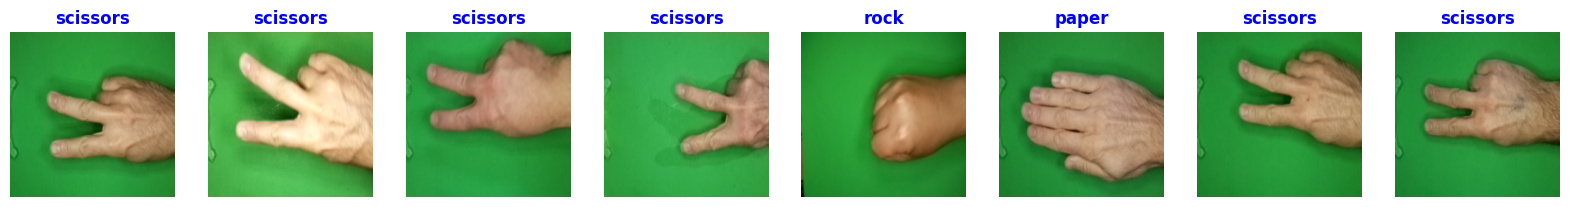

In [ ]:
number_of_images = 8
fig, axes = plt.subplots(1, number_of_images, figsize=(20, 20))
# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

#< TODO: Use a plot to show each image and the label as title
for index, axs in enumerate(axes):
    img_out = ToPILImage()(inputs[index])
    class_label = class_names[classes[index]]
    axs.imshow(img_out)
    axs.axis("off")
    axs.set_title(class_label, fontsize=12, color= 'blue', fontweight='bold')
#TODO >

# Section 2: Model

**[2.1]: Model Creation**
- We build a CNN model using PyTorch framework,
- Pay attention to the syntax in *__ init __()* function where we define the model layers with their properties,
- Each one of the layer objects behaves like a function,
- In the *forward()* function, we establish the sequence of calls that turns inputs (batch of images) into predictions (batch of class probabilities).


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=5)
        self.conv_2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.flatten = nn.Flatten()
        self.dense_1 = nn.Linear(in_features=28224, out_features=2048)
        self.dense_2 = nn.Linear(in_features=2048, out_features=4096)
        self.dense_3 = nn.Linear(in_features=4096, out_features=3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.max_pool_1(x)
        x = self.relu(self.conv_2(x))
        x = self.flatten(x)
        x = self.relu((self.dense_1(x)))
        x = self.relu((self.dense_2(x)))
        x = self.dense_3(x)
        return x

**[2.2] Model run**
- Here we instantiate the CNN model and make a sample run (forward pass),
- We will use a zeros filled images as input to demonstrate this.

In [ ]:
cnn_0 = CNN()
cnn_0 = cnn_0.to('cuda:0')
inputs = torch.zeros([5,3,224,224]).to('cuda:0') # create "fake" input to run cnn_0 a first time, for allocation (starting point)
print("Input type = ", inputs.type())
sample = cnn_0(inputs)
print("Predicted Outputs = ", sample)

Input type =  torch.cuda.FloatTensor
Predicted Outputs =  tensor([[-0.0037,  0.0036,  0.0205],
        [-0.0037,  0.0036,  0.0205],
        [-0.0037,  0.0036,  0.0205],
        [-0.0037,  0.0036,  0.0205],
        [-0.0037,  0.0036,  0.0205]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


**[2.3] Saving model**

- We save the model weights without training.
- We will always restart the model from this `untrained` weights each time we want to retrain it.

In [ ]:
# save checkpoint
torch.save({
            'model_state_dict': cnn_0.state_dict(),
            }, 'untrained')

**[2.4] Model init**
- We pack only model instantiation and loading of untrained weights as a function, for ease of use.

In [ ]:
def get_new_model(lr):
    new_cnn = CNN()
    new_optimizer = torch.optim.SGD(new_cnn.parameters(), lr=lr)
    startpoint = torch.load('untrained')
    new_cnn.load_state_dict(startpoint['model_state_dict'])
    new_cnn = new_cnn.to('cuda:0')
    return new_cnn, new_optimizer

**[2.5] Model overview**
- Here is an overview of the model's architecture:

In [ ]:
from torchsummary import summary
summary(cnn_0, (3, 224, 224))    # provide "summary" with model and input data size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 220, 220]             608
              ReLU-2          [-1, 8, 220, 220]               0
         MaxPool2d-3            [-1, 8, 44, 44]               0
            Conv2d-4           [-1, 16, 42, 42]           1,168
              ReLU-5           [-1, 16, 42, 42]               0
           Flatten-6                [-1, 28224]               0
            Linear-7                 [-1, 2048]      57,804,800
              ReLU-8                 [-1, 2048]               0
            Linear-9                 [-1, 4096]       8,392,704
             ReLU-10                 [-1, 4096]               0
           Linear-11                    [-1, 3]          12,291
Total params: 66,211,571
Trainable params: 66,211,571
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Fo

# Section 3: Training and evaluation functions

**[3.1] Training function**

- This - *incomplete* - function will be used to complete one training step.
- For now it takes batch of images *inputs*, the corresponding batch of labels *labels*, and a model *cnn_model* as input arguments.
- It then returns the loss between the model's predictions and the labels.
- Again, pay attention to the *cnn_model* object. It acts as a **function** here - takes the batch of images and returns the batch of predictions.

In [ ]:
def train_step(inputs, labels, cnn_model):
    cnn_model.train()
    data = inputs.to('cuda:0')
    outp = cnn_model(data)
    loss = torch.mean(torch.nn.CrossEntropyLoss()(outp.to('cpu'), labels)).item()
    del data
    del outp
    torch.cuda.empty_cache()
    return loss

**[3.2] Inference function**
- Similarly, the following function runs an inference of the model on a batch of input data.
- It also computes the accuracy of the model on a batch.

In [ ]:
def eval_step(inputs, labels, cnn_model):
    cnn_model.eval()
    data = inputs.to('cuda:0')
    outp = cnn_model(data)
    pred = torch.argmax(outp, axis=1)
    acc = torch.mean((labels == pred.to('cpu')).float())
    del data
    del pred
    torch.cuda.empty_cache()
    return acc

### TODO 2:
- Run the model on the training set for 100 iterations.
- Report the loss at each iteration.
- Plot and comment; what is missing?

In [ ]:

average_training_losses = []
average_val_accs = []

iteration = 0
log_iter = 2
max_iter = 100
start_t = timer()
stopped = False

for epoch in range(10):
    training_losses = []
    for (x_train_in, y_train_in) in train_dataloader:
        iteration += 1
        loss = # TODO: invoke the train step
        training_losses.append(loss)

        if iteration % log_iter == 0:
            avg_loss = # TODO: calculate the average loss
            average_training_losses.append(avg_loss)
            training_losses = []

            val_accs = []
            for x_val_in, y_val_in in val_dataloader:
                acc = # TODO: invoke the evaluation step
                val_accs.append(acc)
            avg_acc = sum(val_accs) / len(val_accs)
            average_val_accs.append(avg_acc)

            print("ITER {:0>4d}: training loss = {:.4f} | [EVAL]: validation accuracy = {:.4f}".format(iteration, avg_loss, avg_acc))
            print("_"*100)

        if iteration >= max_iter:
            stopped = True
            break
    if stopped:
        break


end_t = timer()
print("time_elapsed: {}".format(end_t - start_t))

fig = plt.figure()

ax = fig.add_subplot(121)
intervals = np.arange(len(average_training_losses))
ax.plot(intervals, average_training_losses)
ax.set_xlabel("iteration * {}".format(log_iter))
ax.set_ylabel("classification loss")

ax = fig.add_subplot(122)
intervals = np.arange(len(average_val_accs))
ax.plot(intervals, average_val_accs)
ax.set_xlabel("iteration * {}".format(log_iter))
ax.set_ylabel("validation accuracy")

print("Evaluation accuracy = ", average_val_accs[-1])

# clear GPU cache memory
torch.cuda.empty_cache()


SyntaxError: invalid syntax (<ipython-input-17-f46538a223b8>, line 14)

**Questions:**
- Why is the training loss not decreasing?
- Why is the validation accuracy not increasing?


### TODO 3:
- Fix the *train_step* function to incorporate the following updates:
  - Compute gradients for all variables in the model
  - To each variable, subtract its gradient scaled by a 0.01 learning rate

In [ ]:
LEARNING_RATE = 0.005
optimizer = torch.optim.SGD(cnn_0.parameters(), lr=LEARNING_RATE)

def train_step(inputs, labels, cnn_model, optim):
    cnn_model.train()
    data = inputs.to('cuda:0')
    #TODO: optimizer zero gradient <

    #>
    outp = cnn_model(data)
    loss = torch.mean(torch.nn.CrossEntropyLoss()(outp.to('cpu'), labels))
    #TODO: write the two steps of optimization <

    #>
    del data
    del outp
    torch.cuda.empty_cache()
    return loss.item()

### TODO 4:
- Train the model on the training set for 2000 iterations.
- Remember to initialize the model from the untrained weights.
- At every 100-th iteration, validate and report the average training loss (over the 100 previous iterations) and avaerage validation accuracy.
- Plot it.

In [ ]:
average_training_losses = []
average_val_accs = []

iteration = 0
log_iter = # TODO
max_iter = # TODO
epochs = 10000
stopped = False
start_t = timer()

#TODO : restart model
cnn_0, optimizer = ...
#>

for epoch in range(epochs):
    training_losses = []
    for (x_train_in, y_train_in) in #TODO: right data loader
        iteration += 1
        loss = train_step(x_train_in, y_train_in, cnn_0, optimizer)
        training_losses.append(loss)

        if iteration % log_iter == 0:
            avg_loss = sum(training_losses) / len(training_losses)
            average_training_losses.append(avg_loss)
            training_losses = []

            val_accs = []
            for x_val_in, y_val_in in val_dataloader:
                acc = eval_step(x_val_in, y_val_in, cnn_0)
                val_accs.append(acc)
            avg_acc = sum(val_accs) / len(val_accs)
            average_val_accs.append(avg_acc)

            print("ITER {:0>6d}: training loss = {:.4f} | [EVAL]: validation accuracy = {:.4f}".format(iteration, avg_loss, avg_acc))
            print("_"*100)

        if iteration >= max_iter:
            stopped = True
            break
    if stopped:
      break


end_t = timer()
print("time_elapsed: {}".format(end_t - start_t))

fig = plt.figure()

ax = fig.add_subplot(121)
intervals = np.arange(len(average_training_losses))
ax.plot(intervals, average_training_losses)
ax.set_xlabel("iteration * {}".format(log_iter))
ax.set_ylabel("classification loss")

ax = fig.add_subplot(122)
intervals = np.arange(len(average_val_accs))
ax.plot(intervals, average_val_accs)
ax.set_xlabel("iteration * {}".format(log_iter))
ax.set_ylabel("validation accuracy")

print("Evaluation accuracy = ", average_val_accs[-1])

# clear GPU cache memory
torch.cuda.empty_cache()


### TODO 5:
- Evaluate the trained model on the training set, then on the test set.
- Report the average accuracy.
- Comment.

In [ ]:
train_accs = []
for x_train_in, y_train_in in train_dataloader:
    #TODO: evaluate on train data <


    #>

average_train_acc = sum(train_accs) / len(train_accs)
print("ACCURACY - TRAINING SET: {}".format(average_train_acc))


test_accs = []
for x_test_in, y_test_in in test_dataloader:
    #TODO: evaluate on test data <


    #>

average_test_acc = sum(test_accs) / len(test_accs)
print("ACCURACY - TEST SET: {}".format(average_test_acc))

### TODO 6:

- Retrain the model on the smaller training data (5% train data).
- Here, we repeat the task `TODO 4` but on a smaller train set to understand the importance of large data.
- Don't forget to reset the model's weights from untrained checkpoint.
- Plot the training losses, and validation accuracies.

In [ ]:
average_training_losses = []
average_val_accs = []

iteration = 0
log_iter = 100
max_iter = 2000
epochs = 10000
stopped = False
start_t = timer()


# TODO:  restart model <
cnn_0, optimizer = ...
#>

for epoch in range(epochs):
    training_losses = []
    for (x_train_in, y_train_in) in # TODO: right dataset loader
        iteration += 1
        loss = train_step(x_train_in, y_train_in, cnn_0, optimizer)
        training_losses.append(loss)

        if iteration % log_iter == 0:
            avg_loss = sum(training_losses) / len(training_losses)
            average_training_losses.append(avg_loss)
            training_losses = []

            val_accs = []
            for x_val_in, y_val_in in val_dataloader:
                acc = eval_step(x_val_in, y_val_in, cnn_0)
                val_accs.append(acc)
            avg_acc = sum(val_accs) / len(val_accs)
            average_val_accs.append(avg_acc)

            print("ITER {:0>6d}: training loss = {:.4f} | [EVAL]: validation accuracy = {:.4f}".format(iteration, avg_loss, avg_acc))
            print("_"*100)

        if iteration >= max_iter:
            stopped = True
            break
    if stopped:
        break


end_t = timer()
print("time_elapsed: {}".format(end_t - start_t))

fig = plt.figure()

ax = fig.add_subplot(121)
intervals = np.arange(len(average_training_losses))
ax.plot(intervals, average_training_losses)
ax.set_xlabel("iteration * {}".format(log_iter))
ax.set_ylabel("classification loss")

ax = fig.add_subplot(122)
intervals = np.arange(len(average_val_accs))
ax.plot(intervals, average_val_accs)
ax.set_xlabel("iteration * {}".format(log_iter))
ax.set_ylabel("validation accuracy")

print("Evaluation accuracy = ", average_val_accs[-1])

# TODO: clear GPU cache memory <

#>

*Similarly,*
- Evaluate the small dataset trained model on the small training set, then on the test set.
- Report the average accuracy.
- Comment your observation.

In [ ]:
train_accs = []
for x_train_in, y_train_in in train_small_dataloader:
    acc = eval_step(x_train_in, y_train_in, cnn_0)
    train_accs.append(acc)

average_train_acc = sum(train_accs) / len(train_accs)
print("ACCURACY - TRAINING SET: {}".format(average_train_acc))


test_accs = []
for x_test_in, y_test_in in test_dataloader:
    acc = eval_step(x_test_in, y_test_in, cnn_0)
    test_accs.append(acc)

average_test_acc = sum(test_accs) / len(test_accs)
print("ACCURACY - TEST SET: {}".format(average_test_acc))

# Section 4: Performance improvement

**[4.1] Model babysitting**

**Question**
- Who can we improve the performance of the model if we only have a small dataset?
- *This case can be similar to your internship projects and real-world problems.*



**Solutions**
- There can be a lot of things to try, I will list them and you will try them unassisted to see which works best for you.
- If you can train your model on small dataset and get a test performance equal or higher than the one we trained on the large training data, we will get a beautiful gift from me.


**List of strategies to try:**
1. Data augumentation
2. Weight regularization
3. Hyperparameter tuning (e.g. learning rate, batch size, weight decay, etc. *find more*)
4. Early stopping
5. Dropout
6. Batch normalization
7. Intuitive objective loss function
8. Some network layer modification
9. *Find more*

# TODO 7

- We start with the first suggestion : Data augmentation (normalization and horizontal flipping)
- We rebuild our data pipeline with new transformation such as rotation, feel free to add more.
- Then we retrain the model on the small dataset that has been augmented and test the performance.

**[TODO 7.1] THE CHANGES**

In [ ]:
# Data preprocessing:  #TODO
transform_rand = torchvision.transforms.Compose([
    ToTensor(),
    #TODO:
    ...
    # Add data preprocessing (normalization)
    # Add augmentation style (horizontal flipping)
    #>
    Resize(size=(224,224)),
])

# full dataset
full_dataset = torchvision.datasets.ImageFolder(root=filepath, transform=transform)
class_names = full_dataset.classes
print("Dataset classes = ", class_names)


# split data into train/val/test sets
items = np.random.permutation(len(full_dataset))
val_ratio = 0.1
test_ratio = 0.1
train_items = items[0:int((1.0-val_ratio-test_ratio)*len(full_dataset))]
train_dataset = Subset(full_dataset, train_items)


# build a dataloader for your dataset
BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# lets create a small dataset from the train set (containing only 5% of the train set)
train_small_indices = np.random.permutation(train_items[0:int(0.05*len(train_items))])
train_small_dataset = Subset(full_dataset, train_small_indices)
train_small_aug_dataloader = DataLoader(train_small_dataset, batch_size=BATCH_SIZE, shuffle=True)
print("Size: Large train set [{}] vs Small train set [{}]".format(len(train_dataset), len(train_small_dataset)))


**[TODO 7.2] Training**


In [ ]:

average_training_losses = []
average_val_accs = []

iteration = 0
log_iter = 100
max_iter = 2000
epochs = 10000
stopped = False
start_t = timer()

# TODO: restart model
cnn_0, optimizer = ...


# TODO: write the training loop (make sure to use 'train_small_aug_dataloader') <


#>

end_t = timer()
print("time_elapsed: {}".format(end_t - start_t))

fig = plt.figure()

ax = fig.add_subplot(121)
intervals = np.arange(len(average_training_losses))
ax.plot(intervals, average_training_losses)
ax.set_xlabel("iteration * {}".format(log_iter))
ax.set_ylabel("classification loss")

ax = fig.add_subplot(122)
intervals = np.arange(len(average_val_accs))
ax.plot(intervals, average_val_accs)
ax.set_xlabel("iteration * {}".format(log_iter))
ax.set_ylabel("validation accuracy")

print("Evaluation accuracy = ", average_val_accs[-1])

# clear GPU cache memory
torch.cuda.empty_cache()


**[TODO 7.3] Testing**

In [ ]:
# TODO: write the testing loop on the train small data <


#>


# TODO: write the testing loop on the test data <


#>

# TODO 8 - 15

- Now experiment with other remaining strategies of improving the model performance.
- For each strategy, show TODO x.1 CHANGES, TODO x.2 Training, and TOD x.3 Testing.
- Get innovative and beat the testing performance of 95%!
- Contact me for your gift in the next class.

In [ ]:
# TODO: Take home assignments (very important!)

### Theoretical questions to think about:
- What are the advantages and disadvantages of having a large validation set?
- Same question for a small one.
- Why do we even have a validation set at all? Why not directly use the test set?
- Take another look at the model we used. Can you point out any issues with it?
- Manufacturing small examples of overfitting was actually quite challenging. To do this, a certain amount of labels (20% of the training set) had to be corrupted. How does that drive the model into overfitting?